In [1]:
#It turns out that finding the edges in an image is a very common task in computer vision and is surprisingly straightforward
#. To do it, we use something called a convo‐ lution. A convolution requires nothing more than multiplication and addition

In [2]:
#A convolution applies a kernel across an image. A "kernel" is a little matrix, such as the 3×3 matrix 

In [25]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

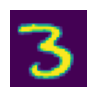

In [44]:
from PIL import Image
import torch
from torchvision.transforms.functional import to_tensor
from fastai.vision.all import *

path = untar_data(URLs.MNIST_SAMPLE)
im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3);

In [45]:
im3_t = tensor(im3)
im3_t[0:3,0:3] * top_edge
tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])
(im3_t[0:3,0:3] * top_edge).sum()

tensor(0.)

In [46]:
df = pd.DataFrame(im3_t[:10,:20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [47]:
#There’s a top edge at cell 5,7. Let’s repeat our calculation there:

In [48]:
(im3_t[4:7,6:9] * top_edge).sum()


tensor(762.)

In [49]:
#There’s a right edge at cell 8,18. What does that give us?

In [50]:
(im3_t[7:10,17:20] * top_edge).sum()

tensor(-29.)

In [51]:
#Let’s look a tiny bit at the math. The filter will take any window of size 3×3 in our images, 
#and if we name the pixel values like this
#a1 a2 a3 a4 a5 a6 a7 a8 a9

#it will return a1+a2+a3−a7−a8−a9. If we are in a part of the image where a1, a2, and a3 add up to the same as a7, a8, and a9, then the terms will cancel each other out and we will get 0

#However, if a1 is greater than a7, a2 is greater than a8, and a3 is greater than a9, we will get a bigger number as a result. So this filter detects horizon‐ tal edges—more precisely, edges where we go from bright parts of the image at the top to darker parts at the bottom.

#Changing our filter to have the row of 1s at the top and the –1s at the bottom would detect horizontal edges that go from dark to light.

#Putting the 1s and –1s in columns versus rows would give us filters that detect vertical edges. Each set of weights will produce a different kind of outcome.


In [52]:
#Let’s create a function to do this for one location, and check that it matches our result from before:

def apply_kernel(row, col, kernel):
    return (im3_t[row-1:row+2,col-1:col+2] * kernel).sum()
apply_kernel(5,7,top_edge)


#But note that we can’t apply it to the corner (e.g., location 0,0), since there isn’t a com‐ plete 3×3 square there.

tensor(762.)

In [53]:
#To get a grid of coordinates, we can use a nested list comprehension, like so:

[[(i,j) for j in range(1,5)] for i in range(1,5)]

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

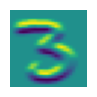

In [54]:
#Here’s the result of applying our kernel over a coordinate grid:

rng = range(1,27)
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])
show_image(top_edge3);


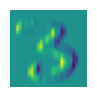

In [55]:
#Now that our image contains negative numbers too, mat plotlib has automatically changed our colors so that white is the smallest number in the image, black the highest, and zeros appear as gray

#We can try the same thing for left edges:

left_edge = tensor([[-1,1,0],
                    [-1,1,0],
                    [-1,1,0]]).float()
left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])
show_image(left_edge3);


In [56]:
#Convolution is such an important and widely used operation that PyTorch has it built in. It’s called F.conv2d (recall that F is a fastai import from torch.nn.functional, as recommended by PyTorch). PyTorch docs tell us that it includes these parameters

#input
#input tensor of shape (minibatch, in_channels, iH, iW)
#weight
#filters of shape (out_channels, in_channels, kH, kW

#Here iH,iW is the height and width of the image (i.e., 28,28), and kH,kW is the height and width of our kernel (3,3)

#PyTorch can apply a convolution to multiple images at the same time. That means we can call it on every item in a batch at once!

#The second trick is that PyTorch can apply multiple kernels at the same time. So let’s create the diagonal-edge kernels too, and then stack all four of our edge kernels into a single tensor:

diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

In [57]:
#To test this, we’ll need a DataLoader and a sample mini-batch. Let’s use the data block API:


mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock),
                      get_items=get_image_files,
                      splitter=GrandparentSplitter(),
                      get_y=parent_label)
dls = mnist.dataloaders(path)
xb,yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

In [58]:
#By default, fastai puts data on the GPU when using data blocks. Let’s move it to the CPU for our examples:

xb,yb = to_cpu(xb),to_cpu(yb)

In [59]:
#One batch contains 64 images, each of 1 channel, with 28×28 pixels. F.conv2d can handle multichannel (color) images too. A channel is a single basic color in an image —for regular full-color images, there are three channels, red, green, and blue. PyTorch represents an image as a rank-3 tensor, with these dimensions:
#[channels, rows, columns]

In [60]:
#We’ll see how to handle more than one channel later in this chapter. Kernels passed to
#F.conv2d need to be rank-4 tensors

#[channels_in, features_out, rows, columns]


#edge_kernels is currently missing one of these: we need to tell PyTorch that the number of input channels in the kernel is one, which we can do by inserting an axis of size one (this is known as a unit axis) in the first location, where the PyTorch docs show in_channels is expected. To insert a unit axis into a tensor, we use the unsqueeze method:

In [61]:
edge_kernels.shape,edge_kernels.unsqueeze(1).shape

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

In [62]:
#This is now the correct shape for edge_kernels. Let’s pass this all to conv2d:

edge_kernels = edge_kernels.unsqueeze(1)
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

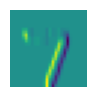

In [63]:
#The output shape shows we have 64 images in the mini-batch, 4 kernels, and 26×26 edge maps (we started with 28×28 images, but lost one pixel from each side as dis‐ cussed earlier). We can see we get the same results as when we did this manually:

show_image(batch_features[0,0]); #to display the first image in the first channel of the batch


In [64]:
#It would be nice to not lose those two pixels on each axis. The way we do that is to add padding

#which is simply additional pixels added around the outside of our image. Most commonly, pixels of zeros are added.



In [65]:
#Strides and Padding, With appropriate padding, we can ensure that the output activation map is the same size as the original image, which can make things a lot simpler when we construct our architectures

#understanding convolution equation page 413.. 

In [ ]:
#First Conv NN, creating CNN


In [67]:
simple_net = nn.Sequential(
        nn.Linear(28*28,30),
        nn.ReLU(),
        nn.Linear(30,1)
)


In [68]:
simple_net


Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [69]:
broken_cnn = sequential(
        nn.Conv2d(1,30, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(30,1, kernel_size=3, padding=1)
)
#One thing to note here is that we didn’t need to specify 28*28 as the input size. That’s because a linear layer needs a weight in the weight matrix for every pixel, so it needs to know how many pixels there are, but a convolution is applied over each pixel auto‐ matically. The weights depend only on the number of input and output channels and the kernel size

In [70]:
#output shape

broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

In [71]:
#This is not something we can use to do classification, since we need a single output activation per image, not a 28×28 map of activations. One way to deal with this is to use enough stride-2 convolutions such that the final layer is size 1. After one stride-2 convolution, the size will be 14×14; after two, it will be 7×7; then 4×4, 2×2, and finally size 1.


In [72]:
#First, we’ll define a function with the basic parameters we’ll use in each convolution:

def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2) 
    if act: res = nn.Sequential(res, nn.ReLU())
    return res


In [73]:
#When we use a stride-2 convolution, we often increase the number of features at the same time. This is because we’re decreasing the number of activations in the activa‐ tion map by a factor of 4; we don’t want to decrease the capacity of a layer by too much at a time.

In [74]:
#Here is how we can build a simple CNN:
simple_cnn = sequential(
    conv(1 ,4), #14x14 
    conv(4 ,8), #7x7 
    conv(8 ,16), #4x4 
    conv(16,32), #2x2 
    conv(32,2, act=False), #1x1 
    Flatten(),
)

In [75]:
#Now the network outputs two activations, which map to the two possible levels in our labels:

In [76]:
simple_cnn(xb).shape

torch.Size([64, 2])

In [77]:
#We can now create our Learner:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)

In [78]:
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

In [79]:
learn.fit_one_cycle(2, 0.01)


epoch,train_loss,valid_loss,accuracy,time
0,0.068123,0.036752,0.987733,00:07
1,0.026694,0.027532,0.989205,00:03


In [80]:
#Understanding Convolution Arithmetic

In [81]:
m = learn.model[0]
m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

In [82]:
#So we have 1 input channel, 4 output channels, and a 3×3 kernel. Let’s check the weights of the first convolution:

m[0].weight.shape

torch.Size([4, 1, 3, 3])

In [83]:
#The summary shows we have 40 parameters, and 4*1*3*3 is 36. What are the other
#four parameters? Let’s see what the bias contains:

m[0].bias.shape

torch.Size([4])

In [84]:
#We can now use this information to clarify our statement in the previous section: “When we use a stride-2 convolution, we often increase the number of features
                     #418 | Chapter 13: Convolutional Neural Networks
#because we’re decreasing the number of activations in the activation map by a factor of 4; we don’t want to decrease the capacity of a layer by too much at a time.”

In [85]:
#There is one bias for each channel. (Sometimes channels are called features or filters when they are not input channels.) The output shape is 64x4x14x14, and this will therefore become the input shape to the next layer. The next layer, according to summary, has 296 parameters. Let’s ignore the batch axis to keep things simple. So, for each of 14*14=196 locations, we are multiplying 296-8=288 weights (ignoring the bias for simplicity), so that’s 196*288=56_448 multiplications at this layer. The next layer will have 7*7*(1168-16)=56_448 multiplications.

In [86]:
#What happened here is that our stride-2 convolution halved the grid size from 14x14 to 7x7, and we doubled the number of filters from 8 to 16, resulting in no overall change in the amount of computation. If we left the number of channels the same in each stride-2 layer, the amount of computation being done in the net would get less and less as it gets deeper. But we know that the deeper layers have to compute seman‐ tically rich features (such as eyes or fur), so we wouldn’t expect that doing less compu‐ tation would make sense.

In [88]:
#Receptive field: area of an image taht is involved in the circulatuin of a layer. 
#THE DEEPER WE ARE IN NETWORK THE LARGER THE RECEPTIVE FIELD FOR AN ACTIVATION. 
#large field means large amount of inpiut image is used to calculate each activation in that layer. 


In [89]:
#Therefore, we’d expect that we’d need more weights for each of our features to handle this increasing complexity. This is another way of saying the same thing we mentioned in the previous section: when we introduce a stride-2 conv in our net‐ work, we should also increase the number of channels.

In [90]:
# Improving training stability

In [92]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/Users/riteshgaire/.fastai/data/mnist_png/training'),Path('/Users/riteshgaire/.fastai/data/mnist_png/testing')]

In [93]:
# The data is in two folders named training and testing, so we have to tell GrandparentSplitter about that (it defaults to train and valid). We do that in the get_dls function, which we define to make it easy to change our batch size later:

def get_dls(bs=64): 
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
        get_items=get_image_files,
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
        ).dataloaders(path, bs=bs)
dls = get_dls()

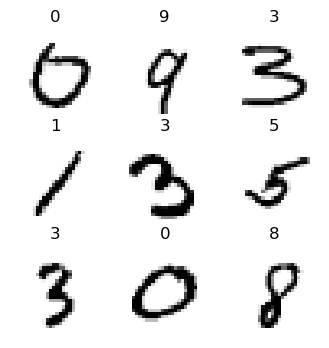

In [94]:
dls.show_batch(max_n=9, figsize=(4,4))

In [95]:
#A Simple Baseline

def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2) 
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [96]:
#we can use a larger kernel in the first layer. If we use a kernel of 5×5 pixels, 25 pixels are being used at each kernel application. Creating eight filters from this will mean the neural net will have to find some useful features:

In [97]:
def simple_cnn(): 
    return sequential(
        conv(1 ,8, ks=5), #14x14 
        conv(8 ,16), #7x7 
        conv(16,32), #4x4 
        conv(32,64), #2x2 
        conv(64,10, act=False), #1x1 
        Flatten(),
)

In [98]:
#As you’ll see in a moment, we can look inside our models while they’re training in order to try to find ways to make them train better. To do this, we use the Activation Stats callback, which records the mean, standard deviation, and histogram of activa‐ tions of every trainable layer (as we’ve seen, callbacks are used to add behavior to the training loop

In [99]:
from fastai.callback.hook import *

In [100]:
#We want to train quickly, so that means training at a high learning rate. Let’s see how
#we go at 0.06:

def fit(epochs=1):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                        metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, 0.10)
    return learn 
learn = fit()

/Users/riteshgaire/anaconda3/lib/python3.11/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.308279,2.304279,0.097400,00:32


In [101]:
#One handy feature of the callbacks passed to Learner is that they are made available automatically, with the same name as the callback class, except in camel_case. So, our ActivationStats callback can be accessed through activation_stats. I’m sure you remember learn.recorder...can you guess how that is implemented? That’s right, it’s a callback called Recorder!

In [102]:
#ActivationStats includes some handy utilities for plotting the activations during training. plot_layer_stats(idx) plots the mean and standard deviation of the acti‐ vations of layer number idx, along with the percentage of activations near zero. Here’s the first layer’s plot

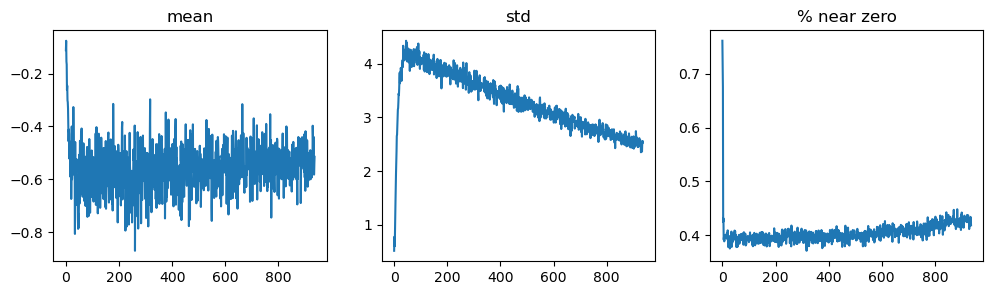

In [103]:
learn.activation_stats.plot_layer_stats(0)

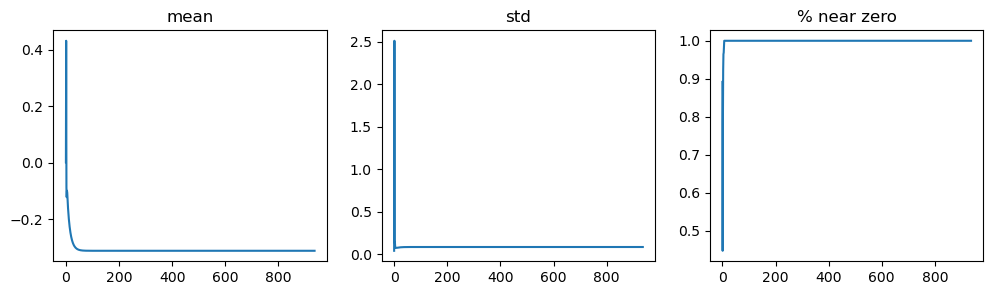

In [104]:
#Generally our model should have a consistent, or at least smooth, mean and standard deviation of layer activations 
#during training. Activations near zero are particularly problematic, because it means we have computation in the 
#model that’s doing noth‐ ing at all (since multiplying by zero gives zero). When you have some zeros in one layer, 
#they will therefore generally carry over to the next layer...which will then create more zeros. 
#Here’s the penultimate layer of our network:

learn.activation_stats.plot_layer_stats(-2)

In [105]:
#As expected, the problems get worse toward the end of the network, as the instability and zero activations compound over 
#layers. Let’s look at what we can do to make training more stable.

In [106]:
#Increase the Batch Size

In [ ]:
#One way to make training more stable is to increase the batch size. Larger batches have gradients that are more accurate, since they’re calculated from more data. On the downside, though, a larger batch size means fewer batches per epoch, which means fewer opportunities for your model to update weights. Let’s see if a batch size of 512 helps:

In [108]:
dls = get_dls(512)
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.614708,0.365941,0.887200,00:24


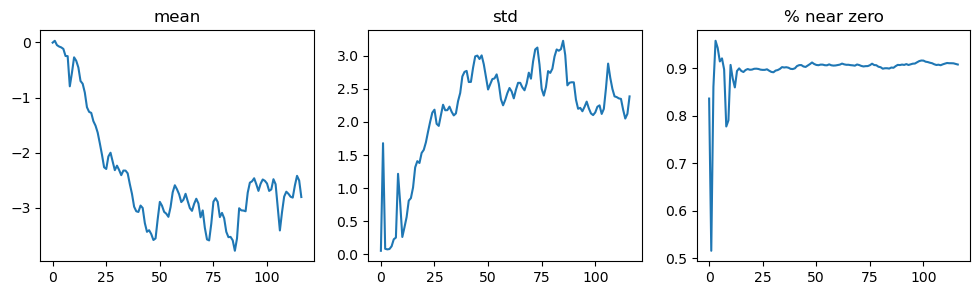

In [109]:
#Let’s see what the penultimate layer looks like:

learn.activation_stats.plot_layer_stats(-2)


In [110]:
#Again, we’ve got most of our activations near zero. Let’s see what else we can do to improve training stability.

In [111]:
#1cycle Training

In [112]:
#Our initial weights are not well suited to the task we’re trying to solve. Therefore, it is dangerous to begin training with a high learning rate: we may very well make the training diverge instantly, as we’ve seen. We probably don’t want to end training with a high learning rate either, so that we don’t skip over a minimum. But we want to train at a high learning rate for the rest of the training period, because we’ll be able to train more quickly that way. Therefore, we should change the learning rate during training, from low, to high, and then back to low again.

In [113]:
#1cycle training allows us to use a much higher maximum learning rate than other types of training, which gives two benefits:

In [114]:
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                        metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn 
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.219906,0.076190,0.975400,00:24


In [115]:
#We can view the learning rate and momentum throughout training by calling plot_sched on learn.recorder. learn.recorder (as the name suggests) records everything that happens during training, including losses, metrics, and hyperparame‐ ters such as learning rate and momentum:

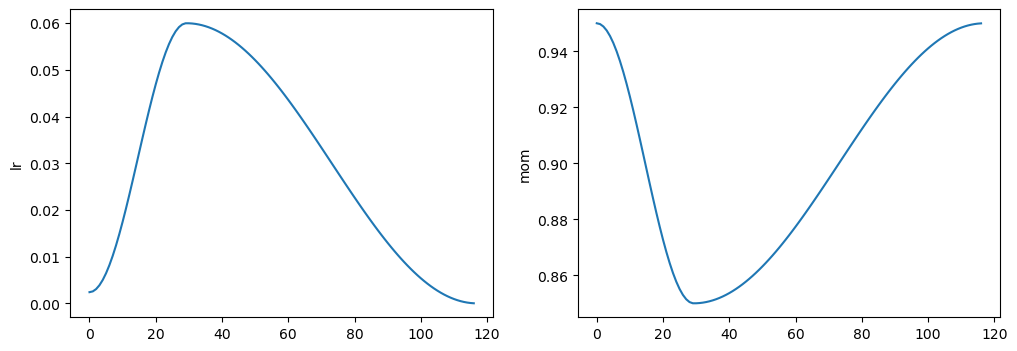

In [116]:
learn.recorder.plot_sched()

In [117]:
#Smith’s original 1cycle paper used a linear warmup and linear annealing. As you can see, we adapted the approach in fastai by combining it with another popular approach: cosine annealing. fit_one_cycle provides the following parameters you can adjust:

In [118]:
#lr_max
#The highest learning rate that will be used (this can also be a list of learning rates for each layer group, or a Python slice object containing the first and last layer group learning rates)

In [119]:
#div
#How much to divide lr_max by to get the starting learning rate

#div_final
#How much to divide lr_max by to get the ending learning rate

#pct_start
#What percentage of the batches to use for the warmup

#moms
#A tuple (mom1,mom2,mom3), where mom1 is the initial momentum, mom2 is the minimum momentum, and mom3 is the final momentum


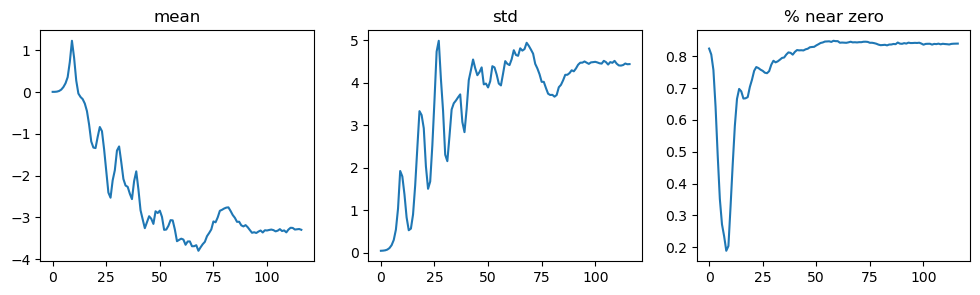

In [120]:
learn.activation_stats.plot_layer_stats(-2)

In [121]:
#the percentage of non zero weight is getting better, although it's qui9te high. We can see evernb more about whats going 
#on our training using color_dim passing it a layer index. 

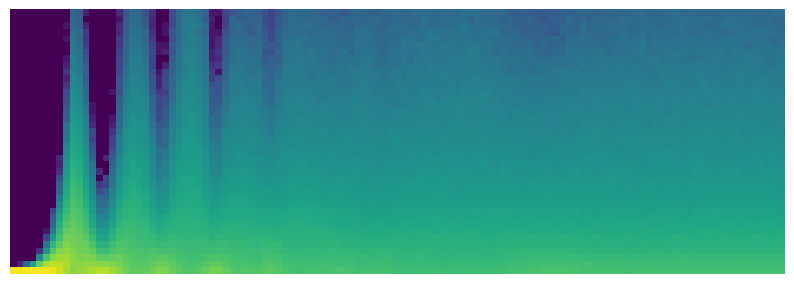

In [122]:
learn.activation_stats.color_dim(-2)

In [123]:
#the idea if color_dim is to plot a histogram of the activations of the layer, which we would hope 
#would follow a smooth pattern such as the normal distribution. 

In [124]:
#The final plot for each layer is made by stacking the histogram of the activations from each batch along the 
#horizontal axis. So each vertical slice in the visualisation repre‐ sents the histogram of activations for a single batch.
#The color intensity corresponds to the height of the histogram; in other words, the number of activations 
#in each histo‐ gram bin.

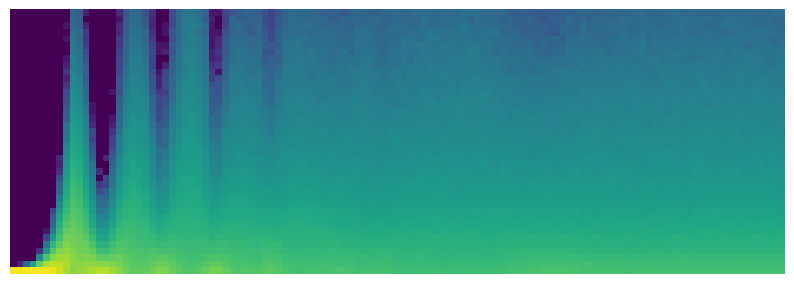

In [131]:
 learn.activation_stats.color_dim(-2)

In [132]:
#This shows a classic picture of “bad training.” We start with nearly all activations 
#at zero—that’s what we see at the far left, with all the dark blue.

#The bright yellow at the bottom represents the near-zero activations. 
#Then, over the first few batches, we see the number of nonzero activations exponentially increasing.

#But it goes too far and collapses! We see the dark blue return, and the bottom becomes bright yellow again. It almost looks like training restarts from scratch. Then we see the activations increase again and collapse again. After repeating this a few times, eventually we see a spread of activations throughout the range.

In [133]:
#It’s much better if training can be smooth from the start. 
#The cycles of exponential increase and then collapse tend to result in a lot of near-zero activations, 
#resulting in slow training and poor final results. One way to solve this problem is to use batch normalization.

In [134]:
#Batch Normalization

In [135]:
#To fix the slow training and poor final results we ended up with in the previous sec‐ tion, 
#we need to fix the initial large percentage of near-zero activations, and then try to maintain a 
#good distribution of activations throughout training.

In [136]:
#Batch normalization (often called batchnorm) works by taking an average of the mean and standard deviations of the 
#activations of a layer and using those to normalize the activations. However, this can cause problems because the 
#network might want some activations to be really high in order to make accurate predictions. So they also added two 
#learnable parameters (meaning they will be updated in the SGD step), usually called gamma and beta. After normalizing 
#the activations to get some new activation vector y, a batchnorm layer returns gamma*y + beta.

In [137]:
#Let’s add a batchnorm layer to conv:

def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)] 
    layers.append(nn.BatchNorm2d(nf))
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.136206,0.061562,0.984800,00:27


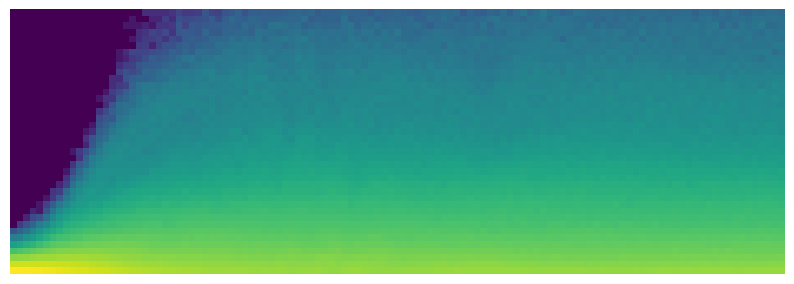

In [140]:
learn.activation_stats.color_dim(-4)


In [141]:
#This is just what we hope to see: a smooth development of activations, with no “crashes.” Batchnorm has really delivered on its promise here! In fact, batchnorm has been so successful that we see it (or something very similar) in nearly all modern neural networks.

In [142]:
#An interesting observation about models containing batch normalization layers is that they tend to generalize better than models that don’t contain them. Although we haven’t as yet seen a rigorous analysis of what’s going on here, most researchers believe that the reason is that batch normalization adds some extra randomness to the training process. Each mini-batch will have a somewhat different mean and standard deviation than other mini-batches. Therefore, the activations will be normalized by different values each time. In order for the model to make accurate predictions, it will have to learn to become robust to these variations. In general, adding additional ran‐ domization to the training process often helps.

In [143]:
#Since things are going so well, let’s train for a few more epochs and see how it goes. In fact, let’s increase the 
#learning rate, since the abstract of the batchnorm paper claimed we should be able to “train at much higher 
#learning rates”:

In [144]:
learn = fit(10, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.227522,0.103573,0.971200,00:25
1,0.096264,0.130377,0.963300,00:25
2,0.066615,0.075507,0.977400,00:25
3,0.053786,0.053795,0.982800,00:25
4,0.047570,0.044588,0.986300,00:25
5,0.036909,0.046579,0.985300,00:25
6,0.026269,0.028598,0.992000,00:25
7,0.016947,0.028766,0.990600,00:26
8,0.009310,0.026451,0.992500,00:26
9,0.005422,0.025578,0.992900,00:26
